In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2

import os

2024-11-09 16:42:46.431368: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 16:42:47.101663: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 16:42:47.105506: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-09 16:42:49.717794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

In [3]:
bg_alphabet = ['A','B', 'V', 'G', 'D', 'E', 'J', 'Z', 'I', 'Ik', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'F', 'H', 'C', 'SH', 'SHt', 'Y', 'Yrm', 'YU', 'YA']

In [4]:
video_folders = ['vid1']

In [5]:
FRAMES_BACK = 3

## Data preprocessing ##

<ol>
    <li>Extract landmarks</li>
    <li>Extract movement info</li>
    <li>Normalize</li>
    <li>Flip R -> L</li>
</ol>

In [6]:
img_name = '14.jpg'
img_path = f'./data/{bg_alphabet[0]}/{video_folders[0]}/{img_name}'
img = cv2.imread(img_path)

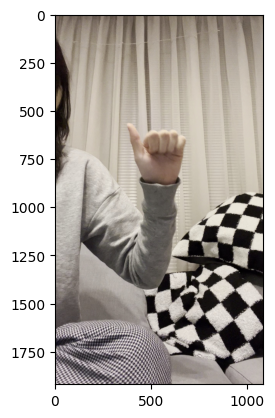

In [7]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
plt.show()

## Load hand landmark finder: ##

In [8]:
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

I0000 00:00:1731163380.597918  224918 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1731163380.629241  225029 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 21.2.6), renderer: AMD Radeon(TM) Vega 10 Graphics (RAVEN, DRM 3.44.0, 5.16.0-051600-generic, LLVM 12.0.0)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [9]:
def get_hand_detection_data(hand_img_path):
    mp_hand_img = mp.Image.create_from_file(hand_img_path)
    detection_result = detector.detect(mp_hand_img)
    return detection_result

In [10]:
hand = get_hand_detection_data(img_path)

In [46]:
dir(hand)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'hand_landmarks',
 'hand_world_landmarks',
 'handedness']

In [141]:
[landmark.y for landmark in hand.hand_landmarks[0]]

[0.5320115685462952,
 0.5017956495285034,
 0.4497997760772705,
 0.401536762714386,
 0.36652088165283203,
 0.4056112468242645,
 0.38890722393989563,
 0.42893895506858826,
 0.43264931440353394,
 0.40481507778167725,
 0.38876670598983765,
 0.43558570742607117,
 0.4319375157356262,
 0.40977415442466736,
 0.38528192043304443,
 0.42897358536720276,
 0.4340115189552307,
 0.4166772961616516,
 0.3927312195301056,
 0.4208625555038452,
 0.43061888217926025]

### Extract landmarks and form csv ###

prev 3 frames - used for convenience, it is actually three frames back with a jump of FREQ

In [11]:
def get_hand_bounding_box(lm_xs, lm_ys):
    """
    takes all xs and ys of the points within dersied bounding box
    returns
    (x1, y1) - lower left corner
    (x2, y2) - upper right corner
    """
    x1, y1 = min(lm_xs), min(lm_ys)
    x2, y2 = max(lm_xs), max(lm_ys)
    return [x1, y1, x2, y2]

In [12]:
def get_box_area(x1, y1, x2, y2):
    return (x2 - x1) * (y2 - y1)

def get_iou(prev_bbox, bbox):
    prev_x1, prev_y1, prev_x2, prev_y2 = prev_bbox
    x1, y1, x2, y2 = bbox

    # bounding box of intersection
    x1_inter = max(x1, prev_x1)
    y1_inter = max(y1, prev_y1)
    x2_inter = min(x2, prev_x2)
    y2_inter = min(y2, prev_y2)

    if x2_inter < x1_inter or y2_inter < y1_inter:
        return 0

    inter_area = get_box_area(x1_inter, y1_inter, x2_inter, y2_inter)
    bbox_area = get_box_area(x1, y1, x2, y2)
    prev_bbox_area = get_box_area(prev_x1, prev_y1, prev_x2, prev_y2)

    union_area = bbox_area + prev_bbox_area - inter_area

    iou = inter_area / union_area
    return iou

In [13]:
def get_hand_landmarks_sample(hand):

    # TO DO: What if more than one hands were found? 
    # TO DO: What if the handedness is not 'Left' - flip HERE
    handedness = hand.handedness[0][0].display_name
    hand_landmarks = hand.hand_landmarks[0];

    x_lms = [landmark.x for landmark in hand.hand_landmarks[0]]
    y_lms = [landmark.y for landmark in hand.hand_landmarks[0]]
    
    return handedness, x_lms, y_lms

In [14]:
def get_hand_movement(x_lms, y_lms, movement_df, this_video_image_count):
    # Save current bounding box
    curr_hand_bbox = get_hand_bounding_box(x_lms, y_lms,)
    hand_movement = curr_hand_bbox
        
    # Save movement of 3 frames back (or FRAMES_BACK amount)
    if this_video_image_count > 1:
        prev_hand_bbox = movement_df[-1][:4]
        prev_hand_ious = movement_df[-1][4:]
        
        # calc IoU for curr and prev frame
        iou1 = get_iou(prev_hand_bbox, curr_hand_bbox)
        hand_movement.append(iou1)

        # -1 because we already calculated the latest iou
        # and here we're just logging "history"
        for i in range(FRAMES_BACK - 1):
            if len(prev_hand_ious) < i:
                conole.log(f'Error: no iou{i} element in movement array for frame before {img_path}')
                continue
            hand_movement.append(prev_hand_ious[i])
            
    # First frame gets None for all ious since there are no prev frames
    else:
        for i in range(FRAMES_BACK):
            hand_movement.append(None)
    return hand_movement

In [54]:
landmarks_df = np.array([])
movement_df = np.array([])

for folder in ['A']:
    
    for subfolder in video_folders:
        curr_folder = f'./data/{folder}/{subfolder}'
        this_video_image_count = 0
        
        for image_name in os.listdir(curr_folder):
            img_path = f'{curr_folder}/{image_name}'
            hand = get_hand_detection_data(img_path)
            
            # Mediapipe will fail to find landmarks in some of the images:
            if len(hand.hand_landmarks) == 0:
                print (f'Error: No hand landmarks were found for file: {img_path}')
                continue

            this_video_image_count += 1
            handedness, x_lms, y_lms = get_hand_landmarks_sample(hand)

            hand_landmarks_sample = [handedness] + x_lms + y_lms
            landmarks_df = np.append(landmarks_df, [hand_landmarks_sample], axis = 0)
            
            print (movement_df, this_video_image_count)
            hand_movement = get_hand_movement(x_lms, y_lms, movement_df, this_video_image_count)
            movement_df = np.append(movement_df, [hand_movement], axis = 0)
                

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [180]:
np.array(movement_df).shape

(17, 7)

In [51]:
a = np.array([[1, 1, 1], [2, 2, 2], [3, 3, 3]])
np.append(a, [[4 , 4, 4]], axis = 0)

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3],
       [4, 4, 4]])

In [32]:
landmarks_df

array(['vid1', 'A', 'Left', '0.47996261715888977', '0.39778807759284973',
       '0.3480469882488251', '0.32684189081192017', '0.3093370795249939',
       '0.4308087229728699', '0.42833924293518066', '0.4190932810306549',
       '0.4155978858470917', '0.475191593170166', '0.47507718205451965',
       '0.45875635743141174', '0.45739656686782837', '0.5185795426368713',
       '0.5199880003929138', '0.49669528007507324', '0.49466055631637573',
       '0.5609656572341919', '0.5667729377746582', '0.5400137305259705',
       '0.5321785807609558', '0.4632514715194702', '0.4288181662559509',
       '0.3872794210910797', '0.34699445962905884', '0.3226342499256134',
       '0.3498383164405823', '0.31705641746520996', '0.351552814245224',
       '0.3755018413066864', '0.34998825192451477', '0.31753385066986084',
       '0.3619043827056885', '0.3807980418205261', '0.35541608929634094',
       '0.3217795491218567', '0.36143314838409424', '0.3829736113548279',
       '0.3698834478855133', '0.3379769

In [19]:
a = np.array([])
a.append(2)
a

AttributeError: 'numpy.ndarray' object has no attribute 'append'